In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [47]:
def build_network():
    network = pypsa.Network()
    snapshots = pd.date_range("2014-01-01", "2014-12-31 23:00", freq="H")

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float("1"), index=network.snapshots)
    GNwt = pd.read_csv("data/ninja_europe_wind_v1/ninja_wind_europe_v1.1_future_nearterm_on-offshore.csv", index_col=0)
    GNwt = GNwt.loc["2014-01-01":"2015-01-01", "DE_ON"]
    snapshots = pd.date_range("2014-01-01", "2014-12-31 23:00", freq="H")
    GNwt = GNwt.reindex(snapshots, method="nearest")
    GSst = pd.read_csv("data/ninja_europe_pv_v1/ninja_pv_europe_v1.1_merra2.csv", index_col=0)

    # GSst = GSst.loc["2014-01-01":"2015-01-01",:]*100
    GSst = GSst.loc["2014-01-01":"2015-01-01", "DE"]
    GSst = GSst.reindex(snapshots, method="nearest")
    
    # # # # bug-fix until PyPSA 0.16.2
    network.snapshot_weightings.name = "weightings"

    network.add("Bus", "DE")
    network.add("Load", "load",
                bus="DE",
                p_set=9000)

    network.add("Generator", "solar",
                bus="DE",
                p_max_pu=GSst,
                p_nom_extendable=True,
                marginal_cost=0.1,
                # Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                capital_cost=35817)

    network.add("Generator", "wind",
                bus="DE",
                p_max_pu=GNwt,
                p_nom_extendable=True,
                marginal_cost=0.2,
                # Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                capital_cost=90596)

    network.add("Generator", "OCGT",
                bus="DE",
                p_nom=1000,
                p_nom_extendable=False,
                marginal_cost=580,
                efficiency=0.39,
                p_max_pu=1)

    network.add("Bus", "DE battery")

    network.add("Store", "DE battery storage",
                bus="DE battery",
                e_nom_extendable=True,
                e_max_pu=1,
                e_cyclic=True,
                capital_cost=10534)

    network.add("Link", "DE battery charge",
                bus0="DE",
                bus1="DE battery",
                efficiency=0.9,
                # p_nom_max=100,
                p_nom_extendable=True,
                capital_cost=14045)

    network.add("Link", "DE battery discharge",
                bus0="DE battery",
                bus1="DE",
                p_nom_extendable=True,
                efficiency=0.9)

    network.add("Bus",
                "DE H2",
                carrier="H2")

#     network.add("Load", "hydrogen_load",
#                 bus="hydrogen",
#                 p_set=200)

    network.add("Link",
                "DE H2 electrolysis",
                bus1="DE H2",
                bus0="DE",
                # p_nom=1000,
                p_nom_extendable=True,
                marginal_cost=0.7,
                efficiency=0.8,
                capital_cost=47073)

    network.add("Link",
                "DE H2 to power",
                bus0="DE H2",
                bus1="DE",
                p_nom_extendable=True,
                efficiency=0.6,
                capital_cost=40452)  # NB: fixed cost is per MWel

    network.add("Store",
                "DE H2 storage",
                bus="DE H2",
                e_nom_extendable=True,
                e_cyclic=True,
                capital_cost= 855)
    return network

def set_parameters_from_optimized(n,n_optim):
    links_i = n.links.index
    n.links.loc[links_i, 'p_nom'] = n_optim.links['p_nom_opt'].reindex(links_i, fill_value=0.)
    n.links.loc[links_i, 'p_nom_extendable'] = False

    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False


    stores_extend_i = n.stores.index[n.stores.e_nom_extendable]
    n.stores.loc[stores_extend_i, 'e_nom'] = n_optim.stores['e_nom_opt'].reindex(stores_extend_i,fill_value=0.)
    n.stores.loc[stores_extend_i, 'e_nom_extendable'] = False
    
    return n

def prepare_network(n):
    n.add("Generator", "load_shedding",
                bus="DE",
                carrier='load',
                marginal_cost=1e6,  # Eur/kWh
                p_nom=1e9  # kW
                )
   # n.loads["p_set"]=n.loads["p_set"]+50
    return n

def get_storeage_bid_de(n, snapshots, bus, charger, discharger):
    charge_efficiency = n.links.efficiency[charger]
    discharge_efficiency = n.links.efficiency[discharger]
    #λ = n.stores_t.mu_state_of_charge.loc[snapshots,"DE H2 storage"]
    λ = n.buses_t.marginal_price.loc[snapshots, bus] 
    if "mu_lower_e" in n.stores_t:
        if bus + " storage" in n.stores_t.mu_lower_e.columns:
            mu_lower = n.stores_t.mu_lower_e.loc[snapshots, bus + " storage"]
        else: mu_lower =0
        if bus + " storage" in n.stores_t.mu_upper_e.columns:
            mu_upper = n.stores_t.mu_upper_e.loc[snapshots, bus + " storage"]
        else: mu_upper=0
    charging_bid = charge_efficiency*λ
    discharging_bid =  λ#/discharge_efficiency
    return charging_bid, discharging_bid  



def solve_network_de_rh_sp(n, opti_n, add_h2_bidding, add_battery_didding, rh_each_snapshot, rh_2w):
    solver_name = "gurobi"

    freq = 1


    length = len(n.snapshots)
    if rh_each_snapshot == True:
        loop_num = len(n.snapshots)-1
        kept = 1
        overlap = 0
        
    if rh_2w == True:
        window = 14 * 24 // freq
        overlap = 7 * 24 // freq
        kept = window - overlap
        loop_num = length // kept
        
        
    if add_h2_bidding == True:
        h2_charging_bid, h2_discharging_bid = get_storeage_bid_de(opti_n,n.snapshots, "DE H2", "DE H2 electrolysis", "DE H2 to power")
        n.links_t.marginal_cost["DE H2 electrolysis"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE H2 electrolysis"] = - h2_charging_bid
        n.links_t.marginal_cost["DE H2 to power"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE H2 to power"] = h2_discharging_bid
    if add_battery_didding == True:
        battery_charging_bid, battery_discharging_bid = get_storeage_bid_de(opti_n,n.snapshots, "DE battery", "DE battery charge", "DE battery discharge")
        n.links_t.marginal_cost["DE battery charge"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE battery charge"] = - battery_charging_bid
        n.links_t.marginal_cost["DE battery discharge"] = 0
        n.links_t.marginal_cost.loc[n.snapshots, "DE battery discharge"] = battery_discharging_bid

    for i in range(loop_num):
        # set initial state of charge
        snapshots = n.snapshots[i * kept:(i + 1) * kept + overlap]        
        if i == 0:
            n.stores.e_initial = opti_n.stores_t.e.iloc[0]
            n.storage_units.state_of_charge_initial = opti_n.storage_units_t.state_of_charge.iloc[-1]
        else:
            n.stores.e_initial = n.stores_t.e.iloc[i * kept - 1]

            n.storage_units.state_of_charge_initial = n.storage_units_t.state_of_charge.iloc[i * kept - 1]
        #n.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, snapshots=snapshots,  keep_shadowprices=True)
        pypsa.linopf.network_lopf(n,snapshots,solver_name="gurobi", solver_logfile=None,
                                     keep_shadowprices=True)
    
    return n

In [24]:
def drop_solved_components(n):
    for key in n_de.buses_t.keys(): #buses_t
        n.buses_t[key] = n.buses_t[key].drop(n.buses_t[key].columns, axis=1)
    
    for key in n_de.lines_t.keys(): #lines_t
        n.lines_t[key] = n.lines_t[key].drop(n.lines_t[key].columns, axis=1)

    for key in n_de.links_t.keys(): #lines_t
        n.links_t[key] = n.links_t[key].drop(n.links_t[key].columns, axis=1)
        
    for key in n_de.storage_units_t.keys(): #storage_units_t
        n.storage_units_t[key] = n.storage_units_t[key].drop(n.storage_units_t[key].columns, axis=1)
        
    for key in list(set(n_de.stores_t.keys())-set(['p', 'e'])): #stores_t #1
        n.stores_t[key] = n.stores_t[key].drop(n.stores_t[key].columns, axis=1)
        
    for key in ['e','p']: #stores_t #2
        n_de.stores_t[key]=pd.DataFrame(index=n_de.stores_t[key].index, columns=n_de.stores_t[key].columns, data=0)

    for key in list(set(n_de.generators_t.keys())-set(['p_max_pu'])): #generators_t
        n.generators_t[key] = n.generators_t[key].drop(n.generators_t[key].columns, axis=1)
        
    return n

In [48]:
# Perfect foresight:  sovled network
#n_de = pypsa.Network("data/de.nc")
n_de = build_network()

In [49]:
n_network = n_de.copy()
n_network.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, keep_shadowprices=True )

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.07s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qt5lyy8x.lp
Reading time = 0.53 seconds
obj: 201480 rows, 96369 columns, 389933 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 201480 rows, 96369 columns and 389933 nonzeros
Model fingerprint: 0xe8a5ab97
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e-01, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 9e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 118147 rows and 21789 columns
Presolve time: 0.28s
Presolved: 83333 rows, 74580 columns, 241239 nonzeros

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 1.929e+05
 Factor NZ  : 1.356e+06 (roughly 70 MBytes of memory)
 Factor Ops : 2.268e+07 (less than 1 second per iteration)
 Threads    : 3

            

  96   8.94456394e+09  1.16867909e+10  1.32e+00 6.66e-01  2.78e+03    18s

Barrier performed 96 iterations in 18.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 105127 iterations and 18.08 seconds
Optimal objective  8.089015697e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 8.09e+09


('ok', 'optimal')

In [27]:
n_operation = n_de.copy()
n_operation = set_parameters_from_optimized(n_operation,n_network)
n_operation = prepare_network(n_operation)
#operation_network.loads["p_set"]=operation_network.loads["p_set"]+50
n_operation.lopf(pyomo=False, solver_name="gurobi", solver_logfile=None, keep_shadowprices=True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.94s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iouwgdzc.lp
Reading time = 0.49 seconds
obj: 219000 rows, 105121 columns, 350400 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 219000 rows, 105121 columns and 350400 nonzeros
Model fingerprint: 0xbdeb960c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 192720 rows and 26759 columns
Presolve time: 0.25s
Presolved: 26280 rows, 78362 columns, 130922 nonzeros

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.504e+04
 Factor NZ  : 3.153e+05 (roughly 45 MBytes of memory)
 Factor Ops : 4.274e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objectiv

INFO:pypsa.linopf:Optimization successful. Objective value: 4.45e+08


('ok', 'optimal')

In [29]:
n_de_rh = n_de.copy()
#n_de_rh = drop_solved_components(n_de_rh)
n_de_rh = set_parameters_from_optimized(n_de_rh, n_operation)
n_de_rh = prepare_network(n_de_rh)
n_de_rh.stores.e_cyclic = False
n_de_rh = solve_network_de_rh_sp(n_de_rh, n_operation, add_h2_bidding = False, add_battery_didding = False, rh_each_snapshot = False, rh_2w = True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hzx307df.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x90a4af62
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1250 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2783 columns, 4797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790125e+05   0.000000e+00      0s
    1187    7.9234683e+05   0.000000e+00   0.000000e+00      0s

Solved in 1187 iterations and 0.04 seconds
Optimal objective  7.923468346e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.92e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tihnv13p.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x99d1af73
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7393 rows and 1087 columns
Presolve time: 0.01s
Presolved: 1007 rows, 2946 columns, 4956 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9997136e+02   3.796394e+05   0.000000e+00      0s
    1342    1.1072770e+06   0.000000e+00   0.000000e+00      0s

Solved in 1342 iterations and 0.04 seconds
Optimal objective  1.107277029e+06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.11e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vjs59cdi.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x23441eb9
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7397 rows and 988 columns
Presolve time: 0.01s
Presolved: 1003 rows, 3045 columns, 5054 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.861369e+05   0.000000e+00      0s
    1361    8.9426879e+05   0.000000e+00   0.000000e+00      0s

Solved in 1361 iterations and 0.04 seconds
Optimal objective  8.942687897e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dw47uqk3.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa1f3cb73
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7398 rows and 1007 columns
Presolve time: 0.01s
Presolved: 1002 rows, 3026 columns, 5034 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.886194e+05   0.000000e+00      0s
    1441    6.2264904e+05   0.000000e+00   0.000000e+00      0s

Solved in 1441 iterations and 0.04 seconds
Optimal objective  6.226490352e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.23e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lv8cwgn2.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xf9f0a914
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1179 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2854 columns, 4868 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.781588e+05   0.000000e+00      0s
    1418    6.2643678e+05   0.000000e+00   0.000000e+00      0s

Solved in 1418 iterations and 0.03 seconds
Optimal objective  6.264367765e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.26e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p4przu9g.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0d425b89
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1326 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2707 columns, 4721 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790125e+05   0.000000e+00      0s
    1304    5.3007414e+05   0.000000e+00   0.000000e+00      0s

Solved in 1304 iterations and 0.03 seconds
Optimal objective  5.300741405e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.30e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rk389_2g.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x5a21fd11
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1198 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2835 columns, 4849 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790125e+05   0.000000e+00      0s
    1368    5.1765429e+05   0.000000e+00   0.000000e+00      0s

Solved in 1368 iterations and 0.03 seconds
Optimal objective  5.176542910e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.18e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-l3an44m2.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x22523a2a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1008 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3025 columns, 5039 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.782839e+05   0.000000e+00      0s
    1457    9.4922138e+05   0.000000e+00   0.000000e+00      0s

Solved in 1457 iterations and 0.04 seconds
Optimal objective  9.492213765e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 9.49e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9nx4f__a.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x141aa9df
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7417 rows and 996 columns
Presolve time: 0.01s
Presolved: 983 rows, 3037 columns, 5026 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.275797e+05   0.000000e+00      0s
    1384    1.0097059e+08   0.000000e+00   0.000000e+00      0s

Solved in 1384 iterations and 0.04 seconds
Optimal objective  1.009705928e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5w1ve5va.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xcd8f1809
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7408 rows and 1148 columns
Presolve time: 0.01s
Presolved: 992 rows, 2885 columns, 4883 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.118845e+05   0.000000e+00      0s
    1389    1.9636445e+07   0.000000e+00   0.000000e+00      0s

Solved in 1389 iterations and 0.04 seconds
Optimal objective  1.963644535e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.96e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0nwd599r.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd88b56d1
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7402 rows and 1179 columns
Presolve time: 0.01s
Presolved: 998 rows, 2854 columns, 4858 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.957392e+05   0.000000e+00      0s
    1412    8.4333873e+05   0.000000e+00   0.000000e+00      0s

Solved in 1412 iterations and 0.04 seconds
Optimal objective  8.433387251e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.43e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h2wej4bo.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x419d1816
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7397 rows and 1031 columns
Presolve time: 0.01s
Presolved: 1003 rows, 3002 columns, 5011 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.870927e+05   0.000000e+00      0s
    1482    1.0637789e+06   0.000000e+00   0.000000e+00      0s

Solved in 1482 iterations and 0.04 seconds
Optimal objective  1.063778909e+06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.06e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5zlnapzx.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa8363b17
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7394 rows and 979 columns
Presolve time: 0.01s
Presolved: 1006 rows, 3054 columns, 5066 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.803905e+05   0.000000e+00      0s
    1493    8.5373749e+05   0.000000e+00   0.000000e+00      0s

Solved in 1493 iterations and 0.04 seconds
Optimal objective  8.537374874e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.54e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hjd1oioa.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x389015e8
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1065 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2968 columns, 4982 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.781710e+05   0.000000e+00      0s
    1471    8.2658535e+05   0.000000e+00   0.000000e+00      0s

Solved in 1471 iterations and 0.04 seconds
Optimal objective  8.265853508e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.27e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-oqgr_v3e.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8b3d13f6
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7398 rows and 1087 columns
Presolve time: 0.01s
Presolved: 1002 rows, 2946 columns, 4951 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3999375e+02   3.846445e+05   0.000000e+00      0s
    1417    7.9502662e+05   0.000000e+00   0.000000e+00      0s

Solved in 1417 iterations and 0.04 seconds
Optimal objective  7.950266162e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.95e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j3iu1da0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x607f9fa6
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7394 rows and 961 columns
Presolve time: 0.01s
Presolved: 1006 rows, 3072 columns, 5084 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.793408e+05   0.000000e+00      0s
    1382    8.8948736e+05   0.000000e+00   0.000000e+00      0s

Solved in 1382 iterations and 0.04 seconds
Optimal objective  8.894873581e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.89e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nsjv17yj.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8058a5b4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7401 rows and 921 columns
Presolve time: 0.01s
Presolved: 999 rows, 3112 columns, 5117 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.949234e+05   0.000000e+00      0s
    1438    4.7349580e+07   0.000000e+00   0.000000e+00      0s

Solved in 1438 iterations and 0.04 seconds
Optimal objective  4.734957959e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 4.73e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-cee3jkcp.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd710f139
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7400 rows and 1115 columns
Presolve time: 0.01s
Presolved: 1000 rows, 2918 columns, 4924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.923702e+05   0.000000e+00      0s
    1437    1.4597457e+07   0.000000e+00   0.000000e+00      0s

Solved in 1437 iterations and 0.03 seconds
Optimal objective  1.459745704e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-izkmz5u_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8932d7dd
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1124 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2909 columns, 4923 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790125e+05   0.000000e+00      0s
    1375    5.1615754e+05   0.000000e+00   0.000000e+00      0s

Solved in 1375 iterations and 0.04 seconds
Optimal objective  5.161575442e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.16e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-83fuc8v8.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x963c1907
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 996 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3037 columns, 5051 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.789920e+05   0.000000e+00      0s
    1396    6.1829576e+05   0.000000e+00   0.000000e+00      0s

Solved in 1396 iterations and 0.03 seconds
Optimal objective  6.182957589e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.18e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jetbmg1c.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x9c51afc4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7396 rows and 989 columns
Presolve time: 0.01s
Presolved: 1004 rows, 3044 columns, 5054 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.853764e+05   0.000000e+00      0s
    1432    8.4162315e+05   0.000000e+00   0.000000e+00      0s

Solved in 1432 iterations and 0.04 seconds
Optimal objective  8.416231536e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.42e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3h844p01.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8fce48e4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7399 rows and 962 columns
Presolve time: 0.01s
Presolved: 1001 rows, 3071 columns, 5078 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.914591e+05   0.000000e+00      0s
    1373    8.4627478e+05   0.000000e+00   0.000000e+00      0s

Solved in 1373 iterations and 0.04 seconds
Optimal objective  8.462747802e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.46e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gg4lu1lw.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x466797da
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7396 rows and 954 columns
Presolve time: 0.01s
Presolved: 1004 rows, 3079 columns, 5089 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.821939e+05   0.000000e+00      0s
    1400    6.6850955e+05   0.000000e+00   0.000000e+00      0s

Solved in 1400 iterations and 0.03 seconds
Optimal objective  6.685095525e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.69e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-moxwir9p.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x4d287be0
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1024 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3009 columns, 5023 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.762813e+05   0.000000e+00      0s
    1403    5.8833926e+05   0.000000e+00   0.000000e+00      0s

Solved in 1403 iterations and 0.04 seconds
Optimal objective  5.883392642e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.88e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-mhybaxsc.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x375537be
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7394 rows and 990 columns
Presolve time: 0.01s
Presolved: 1006 rows, 3043 columns, 5055 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.787546e+05   0.000000e+00      0s
    1461    8.4056375e+05   0.000000e+00   0.000000e+00      0s

Solved in 1461 iterations and 0.04 seconds
Optimal objective  8.405637547e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.41e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m1wg0_mi.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x6356e781
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7408 rows and 937 columns
Presolve time: 0.01s
Presolved: 992 rows, 3096 columns, 5094 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.099351e+05   0.000000e+00      0s
    1422    7.1435556e+05   0.000000e+00   0.000000e+00      0s

Solved in 1422 iterations and 0.03 seconds
Optimal objective  7.143555563e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.14e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4597x4zw.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8da56344
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7394 rows and 972 columns
Presolve time: 0.01s
Presolved: 1006 rows, 3061 columns, 5073 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.793751e+05   0.000000e+00      0s
    1456    6.6325558e+05   0.000000e+00   0.000000e+00      0s

Solved in 1456 iterations and 0.04 seconds
Optimal objective  6.632555820e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.63e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-s7axs__p.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd68bbd41
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7396 rows and 960 columns
Presolve time: 0.01s
Presolved: 1004 rows, 3073 columns, 5083 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.852794e+05   0.000000e+00      0s
    1431    7.8836496e+05   0.000000e+00   0.000000e+00      0s

Solved in 1431 iterations and 0.04 seconds
Optimal objective  7.883649618e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.88e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-25fhd1zm.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x69290f0b
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7408 rows and 921 columns
Presolve time: 0.01s
Presolved: 992 rows, 3112 columns, 5110 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.083043e+05   0.000000e+00      0s
    1394    8.4004763e+05   0.000000e+00   0.000000e+00      0s

Solved in 1394 iterations and 0.04 seconds
Optimal objective  8.400476321e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.40e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gb_92k_b.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x70e200fc
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7404 rows and 883 columns
Presolve time: 0.01s
Presolved: 996 rows, 3150 columns, 5152 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.022096e+05   0.000000e+00      0s
    1368    8.6398023e+07   0.000000e+00   0.000000e+00      0s

Solved in 1368 iterations and 0.04 seconds
Optimal objective  8.639802310e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.64e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q11o__rz.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x3834ee25
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7403 rows and 948 columns
Presolve time: 0.01s
Presolved: 997 rows, 3085 columns, 5088 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.989343e+05   0.000000e+00      0s
    1389    6.4896962e+10   0.000000e+00   0.000000e+00      0s

Solved in 1389 iterations and 0.04 seconds
Optimal objective  6.489696232e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 6.49e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nmzw_f2e.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x53d18d72
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7395 rows and 1044 columns
Presolve time: 0.01s
Presolved: 1005 rows, 2989 columns, 5000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.825662e+05   0.000000e+00      0s
    1441    6.4807654e+10   0.000000e+00   0.000000e+00      0s

Solved in 1441 iterations and 0.03 seconds
Optimal objective  6.480765367e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 6.48e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wn7p3wwd.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xff310f34
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7393 rows and 1025 columns
Presolve time: 0.01s
Presolved: 1007 rows, 3008 columns, 5021 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.786477e+05   0.000000e+00      0s
    1465    6.4256151e+05   0.000000e+00   0.000000e+00      0s

Solved in 1465 iterations and 0.04 seconds
Optimal objective  6.425615086e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.43e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ezbhnlw.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x81bc18cb
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7401 rows and 952 columns
Presolve time: 0.01s
Presolved: 999 rows, 3081 columns, 5086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.929094e+05   0.000000e+00      0s
    1399    9.7939442e+05   0.000000e+00   0.000000e+00      0s

Solved in 1399 iterations and 0.04 seconds
Optimal objective  9.793944220e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 9.79e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5rqh0ez9.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xae558716
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7417 rows and 940 columns
Presolve time: 0.01s
Presolved: 983 rows, 3093 columns, 5082 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.275350e+05   0.000000e+00      0s
    1353    3.8346350e+07   0.000000e+00   0.000000e+00      0s

Solved in 1353 iterations and 0.04 seconds
Optimal objective  3.834634960e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.83e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-0d5pkuu9.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x07e69e01
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7396 rows and 934 columns
Presolve time: 0.01s
Presolved: 1004 rows, 3099 columns, 5109 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.857684e+05   0.000000e+00      0s
    1400    3.6162986e+07   0.000000e+00   0.000000e+00      0s

Solved in 1400 iterations and 0.04 seconds
Optimal objective  3.616298611e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.62e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5d49kxxf.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe50cc91e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7394 rows and 964 columns
Presolve time: 0.01s
Presolved: 1006 rows, 3069 columns, 5081 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.797658e+05   0.000000e+00      0s
    1493    8.0727096e+05   0.000000e+00   0.000000e+00      0s

Solved in 1493 iterations and 0.04 seconds
Optimal objective  8.072709582e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.07e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-hgchk970.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x01524a0e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7407 rows and 974 columns
Presolve time: 0.01s
Presolved: 993 rows, 3059 columns, 5058 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.080545e+05   0.000000e+00      0s
    1418    9.0284831e+05   0.000000e+00   0.000000e+00      0s

Solved in 1418 iterations and 0.04 seconds
Optimal objective  9.028483118e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 9.03e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-9odo0h6b.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x40d665d4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7392 rows and 953 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3080 columns, 5094 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.789560e+05   0.000000e+00      0s
    1455    6.6107189e+10   0.000000e+00   0.000000e+00      0s

Solved in 1455 iterations and 0.04 seconds
Optimal objective  6.610718913e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 6.61e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-3ladsi0_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x747bf2b7
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7408 rows and 996 columns
Presolve time: 0.01s
Presolved: 992 rows, 3037 columns, 5035 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.093869e+05   0.000000e+00      0s
    1401    6.6022849e+10   0.000000e+00   0.000000e+00      0s

Solved in 1401 iterations and 0.04 seconds
Optimal objective  6.602284931e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 6.60e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sehnm6s9.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x69702816
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7396 rows and 1032 columns
Presolve time: 0.01s
Presolved: 1004 rows, 3001 columns, 5011 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.839564e+05   0.000000e+00      0s
    1382    3.9436709e+07   0.000000e+00   0.000000e+00      0s

Solved in 1382 iterations and 0.04 seconds
Optimal objective  3.943670871e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 3.94e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rjuhxhpf.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x1e9e6e62
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7395 rows and 1036 columns
Presolve time: 0.01s
Presolved: 1005 rows, 2997 columns, 5008 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.804037e+05   0.000000e+00      0s
    1410    2.8314968e+07   0.000000e+00   0.000000e+00      0s

Solved in 1410 iterations and 0.04 seconds
Optimal objective  2.831496831e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.83e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dul30idd.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xf0eca2ae
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7397 rows and 1014 columns
Presolve time: 0.01s
Presolved: 1003 rows, 3019 columns, 5025 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3999375e+02   3.822730e+05   0.000000e+00      0s
    1380    5.7502529e+07   0.000000e+00   0.000000e+00      0s

Solved in 1380 iterations and 0.04 seconds
Optimal objective  5.750252935e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 5.75e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-sc3_60ke.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xde7a6b86
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7416 rows and 987 columns
Presolve time: 0.01s
Presolved: 984 rows, 3046 columns, 5036 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.255744e+05   0.000000e+00      0s
    1461    8.3002523e+07   0.000000e+00   0.000000e+00      0s

Solved in 1461 iterations and 0.04 seconds
Optimal objective  8.300252297e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.30e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jkxo3076.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x6eb37874
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7418 rows and 927 columns
Presolve time: 0.01s
Presolved: 982 rows, 3106 columns, 5094 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.305131e+05   0.000000e+00      0s
    1414    1.0145100e+11   0.000000e+00   0.000000e+00      0s

Solved in 1414 iterations and 0.03 seconds
Optimal objective  1.014510002e+11


INFO:pypsa.linopf:Optimization successful. Objective value: 1.01e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5crmy09s.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xf61f43e1
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7402 rows and 910 columns
Presolve time: 0.01s
Presolved: 998 rows, 3123 columns, 5127 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.964635e+05   0.000000e+00      0s
    1447    3.0002473e+11   0.000000e+00   0.000000e+00      0s

Solved in 1447 iterations and 0.04 seconds
Optimal objective  3.000247338e+11


INFO:pypsa.linopf:Optimization successful. Objective value: 3.00e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-e0q941mh.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xeca1e48b
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7412 rows and 964 columns
Presolve time: 0.01s
Presolved: 988 rows, 3069 columns, 5063 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.170776e+05   0.000000e+00      0s
    1344    1.9860408e+11   0.000000e+00   0.000000e+00      0s

Solved in 1344 iterations and 0.03 seconds
Optimal objective  1.986040773e+11


INFO:pypsa.linopf:Optimization successful. Objective value: 1.99e+11
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qloo96wr.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x51a5d21a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7393 rows and 961 columns
Presolve time: 0.01s
Presolved: 1007 rows, 3072 columns, 5085 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790332e+05   0.000000e+00      0s
    1377    5.6699287e+10   0.000000e+00   0.000000e+00      0s

Solved in 1377 iterations and 0.04 seconds
Optimal objective  5.669928735e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 5.67e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4j4amrbn.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x2d1c259a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7439 rows and 1144 columns
Presolve time: 0.01s
Presolved: 961 rows, 2889 columns, 4856 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.737103e+05   0.000000e+00      0s
    1403    5.6628765e+10   0.000000e+00   0.000000e+00      0s

Solved in 1403 iterations and 0.03 seconds
Optimal objective  5.662876531e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2xf5ftir.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x52b2d8ac
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7393 rows and 1389 columns
Presolve time: 0.01s
Presolved: 1007 rows, 2644 columns, 4654 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8000000e+03   3.789000e+05   0.000000e+00      0s
     999    6.3339002e+05   0.000000e+00   0.000000e+00      0s

Solved in 999 iterations and 0.03 seconds
Optimal objective  6.333900167e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-71k_l5hf.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8a3dd2d5
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1310 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2723 columns, 4737 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.790125e+05   0.000000e+00      0s
    1221    7.2191072e+05   0.000000e+00   0.000000e+00      0s

Solved in 1221 iterations and 0.03 seconds
Optimal objective  7.219107200e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.22e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-a11n1ceu.lp
Reading time = 0.01 seconds
obj: 4800 rows, 2305 columns, 7678 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4800 rows, 2305 columns and 7678 nonzeros
Model fingerprint: 0x39820402
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 4225 rows and 622 columns
Presolve time: 0.01s
Presolved: 575 rows, 1683 columns, 2829 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8000000e+03   2.169000e+05   0.000000e+00      0s
     771    4.6949563e+05   0.000000e+00   0.000000e+00      0s

Solved in 771 iterations and 0.02 seconds
Optimal objective  4.694956322e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.69e+05


In [30]:
# n_de_rh_sp_h2 = n_de.copy()
# #n_de_rh_sp_h2 = drop_solved_components(n_de_rh_sp_h2)
# n_de_rh_sp_h2 = set_parameters_from_optimized(n_de_rh_sp_h2, n_operation)
# n_de_rh_sp_h2 = prepare_network(n_de_rh_sp_h2)
# n_de_rh_sp_h2.stores.e_cyclic = False
# n_de_rh_sp_h2 = solve_network_de_rh_sp(n_de_rh_sp_h2, n_operation, add_h2_bidding = True, add_battery_didding = False, rh_each_snapshot = True, rh_2w = False)

In [31]:
n_de_rh_2w_h2 = n_de.copy()
#n_de_rh_2w_h2 = drop_solved_components(n_de_rh_2w_h2)
n_de_rh_2w_h2 = set_parameters_from_optimized(n_de_rh_2w_h2, n_operation)
n_de_rh_2w_h2 = prepare_network(n_de_rh_2w_h2)
n_de_rh_2w_h2.stores.e_cyclic = False
n_de_rh_2w_h2 = solve_network_de_rh_sp(n_de_rh_2w_h2, n_operation, add_h2_bidding = True, add_battery_didding = False, rh_each_snapshot = False, rh_2w = True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8cdfgot0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xfa532c50
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1250 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2783 columns, 4797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   2.341036e+07   0.000000e+00      0s
     993    6.9023541e+04   0.000000e+00   0.000000e+00      0s

Solved in 993 iterations and 0.05 seconds
Optimal objective  6.902354123e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 6.90e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_hu8hzpq.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xb567cb75
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7442 rows and 1136 columns
Presolve time: 0.02s
Presolved: 958 rows, 2897 columns, 4858 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0484688e+06   1.120657e+07   0.000000e+00      0s
    1293    5.8195883e+05   0.000000e+00   0.000000e+00      0s

Solved in 1293 iterations and 0.05 seconds
Optimal objective  5.819588303e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.82e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-56nfqg25.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe9dfa917
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7432 rows and 1023 columns
Presolve time: 0.01s
Presolved: 968 rows, 3010 columns, 4984 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.249427e+07   0.000000e+00      0s
    1147    4.2141004e+05   0.000000e+00   0.000000e+00      0s

Solved in 1147 iterations and 0.04 seconds
Optimal objective  4.214100359e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.21e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ir29yyav.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa14124cd
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7435 rows and 1044 columns
Presolve time: 0.01s
Presolved: 965 rows, 2989 columns, 4960 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.990862e+07   0.000000e+00      0s
    1211    3.5890545e+05   0.000000e+00   0.000000e+00      0s

Solved in 1211 iterations and 0.05 seconds
Optimal objective  3.589054504e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.59e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-zucv0shi.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x9410c45e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7421 rows and 1208 columns
Presolve time: 0.01s
Presolved: 979 rows, 2825 columns, 4810 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.446788e+07   0.000000e+00      0s
    1136    4.0623646e+05   0.000000e+00   0.000000e+00      0s

Solved in 1136 iterations and 0.04 seconds
Optimal objective  4.062364609e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.06e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ryd5q6b2.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x7afadddc
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7425 rows and 1359 columns
Presolve time: 0.01s
Presolved: 975 rows, 2674 columns, 4655 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.370800e+07   0.000000e+00      0s
    1152    3.7025326e+05   0.000000e+00   0.000000e+00      0s

Solved in 1152 iterations and 0.04 seconds
Optimal objective  3.702532592e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.70e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5ge972nq.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe67ba84c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7406 rows and 1212 columns
Presolve time: 0.01s
Presolved: 994 rows, 2821 columns, 4821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.787591e+07   0.000000e+00      0s
    1185    4.3893008e+05   0.000000e+00   0.000000e+00      0s

Solved in 1185 iterations and 0.04 seconds
Optimal objective  4.389300820e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.39e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-i9l61ysu.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x37a98445
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7405 rows and 1021 columns
Presolve time: 0.01s
Presolved: 995 rows, 3012 columns, 5013 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   2.574229e+07   0.000000e+00      0s
    1125    7.2773017e+05   0.000000e+00   0.000000e+00      0s

Solved in 1125 iterations and 0.04 seconds
Optimal objective  7.277301706e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.28e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dugbdm1b.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x88fa94b1
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 971 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3062 columns, 5076 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   3.067300e+07   0.000000e+00      0s
    1392    6.1280005e+05   0.000000e+00   0.000000e+00      0s

Solved in 1392 iterations and 0.05 seconds
Optimal objective  6.128000516e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.13e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-09c3lhdl.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe626e967
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7442 rows and 1182 columns
Presolve time: 0.01s
Presolved: 958 rows, 2851 columns, 4815 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.109554e+07   0.000000e+00      0s
    1348    2.7048670e+05   0.000000e+00   0.000000e+00      0s

Solved in 1348 iterations and 0.05 seconds
Optimal objective  2.704867025e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.70e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xofcl62q.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x7b356532
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7431 rows and 1208 columns
Presolve time: 0.01s
Presolved: 969 rows, 2825 columns, 4800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.266285e+07   0.000000e+00      0s
    1149    6.3250505e+05   0.000000e+00   0.000000e+00      0s

Solved in 1149 iterations and 0.04 seconds
Optimal objective  6.325050474e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.33e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iu9va6bl.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x56f11025
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7414 rows and 1048 columns
Presolve time: 0.01s
Presolved: 986 rows, 2985 columns, 4977 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.596027e+07   0.000000e+00      0s
    1396    6.9513385e+05   0.000000e+00   0.000000e+00      0s

Solved in 1396 iterations and 0.04 seconds
Optimal objective  6.951338482e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.95e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-v4m3umdt.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x468dcacb
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7439 rows and 1024 columns
Presolve time: 0.01s
Presolved: 961 rows, 3009 columns, 4976 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.143964e+07   0.000000e+00      0s
    1210    2.2453957e+05   0.000000e+00   0.000000e+00      0s

Solved in 1210 iterations and 0.05 seconds
Optimal objective  2.245395700e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.25e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-76smq0y0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x83efc05c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7442 rows and 1115 columns
Presolve time: 0.01s
Presolved: 958 rows, 2918 columns, 4882 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.108927e+07   0.000000e+00      0s
    1184    2.3061940e+05   0.000000e+00   0.000000e+00      0s

Solved in 1184 iterations and 0.05 seconds
Optimal objective  2.306194045e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.31e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-8lqmk5qf.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x2aca501b
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7431 rows and 1120 columns
Presolve time: 0.01s
Presolved: 969 rows, 2913 columns, 4885 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0484688e+06   1.283214e+07   0.000000e+00      0s
    1377    3.5525862e+05   0.000000e+00   0.000000e+00      0s

Solved in 1377 iterations and 0.04 seconds
Optimal objective  3.552586233e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.55e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2om80i5l.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x06a437a4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7429 rows and 996 columns
Presolve time: 0.01s
Presolved: 971 rows, 3037 columns, 5014 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.706463e+07   0.000000e+00      0s
    1341    4.4783947e+05   0.000000e+00   0.000000e+00      0s

Solved in 1341 iterations and 0.05 seconds
Optimal objective  4.478394709e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.48e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-uqv3_85e.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x4b25618b
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7403 rows and 923 columns
Presolve time: 0.01s
Presolved: 997 rows, 3110 columns, 5113 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.864833e+07   0.000000e+00      0s
    1402    5.4045586e+05   0.000000e+00   0.000000e+00      0s

Solved in 1402 iterations and 0.05 seconds
Optimal objective  5.404558577e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.40e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n2u685an.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0577bc71
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7425 rows and 1140 columns
Presolve time: 0.02s
Presolved: 975 rows, 2893 columns, 4874 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.388893e+07   0.000000e+00      0s
    1394    3.1040820e+05   0.000000e+00   0.000000e+00      0s

Solved in 1394 iterations and 0.06 seconds
Optimal objective  3.104082000e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.10e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-drg6yv6t.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x2f586127
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 1172 columns
Presolve time: 0.01s
Presolved: 960 rows, 2861 columns, 4827 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.692072e+07   0.000000e+00      0s
    1415    1.9779576e+05   0.000000e+00   0.000000e+00      0s

Solved in 1415 iterations and 0.05 seconds
Optimal objective  1.977957558e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_rp8_rca.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xdb389c8e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7416 rows and 1020 columns
Presolve time: 0.01s
Presolved: 984 rows, 3013 columns, 5003 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   2.103671e+07   0.000000e+00      0s
    1367    3.2368167e+05   0.000000e+00   0.000000e+00      0s

Solved in 1367 iterations and 0.04 seconds
Optimal objective  3.236816718e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.24e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-4293d4y_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x717a7d6c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7402 rows and 995 columns
Presolve time: 0.01s
Presolved: 998 rows, 3038 columns, 5042 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.892518e+07   0.000000e+00      0s
    1416    6.0388962e+05   0.000000e+00   0.000000e+00      0s

Solved in 1416 iterations and 0.04 seconds
Optimal objective  6.038896190e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.04e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-wn588wve.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe48fc2d6
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7400 rows and 963 columns
Presolve time: 0.01s
Presolved: 1000 rows, 3070 columns, 5076 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.948976e+07   0.000000e+00      0s
    1439    4.5768857e+05   0.000000e+00   0.000000e+00      0s

Solved in 1439 iterations and 0.05 seconds
Optimal objective  4.576885717e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.58e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ezbf11n8.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x7cf1c3ce
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7434 rows and 992 columns
Presolve time: 0.01s
Presolved: 966 rows, 3041 columns, 5013 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.780114e+07   0.000000e+00      0s
    1167    2.3201039e+05   0.000000e+00   0.000000e+00      0s

Solved in 1167 iterations and 0.05 seconds
Optimal objective  2.320103877e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-22x2eov7.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8c40b77f
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7414 rows and 1046 columns
Presolve time: 0.01s
Presolved: 986 rows, 2987 columns, 4979 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.595054e+07   0.000000e+00      0s
    1215    3.4248865e+05   0.000000e+00   0.000000e+00      0s

Solved in 1215 iterations and 0.04 seconds
Optimal objective  3.424886550e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.42e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q1_l7sgh.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x6a0e4170
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7416 rows and 1012 columns
Presolve time: 0.01s
Presolved: 984 rows, 3021 columns, 5011 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   2.040816e+07   0.000000e+00      0s
    1241    4.9969552e+05   0.000000e+00   0.000000e+00      0s

Solved in 1241 iterations and 0.04 seconds
Optimal objective  4.996955204e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.00e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ukchs8b0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8380b477
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7401 rows and 930 columns
Presolve time: 0.01s
Presolved: 999 rows, 3103 columns, 5108 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.947332e+07   0.000000e+00      0s
    1423    4.4180775e+05   0.000000e+00   0.000000e+00      0s

Solved in 1423 iterations and 0.05 seconds
Optimal objective  4.418077536e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.42e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gg8bsx2d.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x7f05e46b
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7427 rows and 1005 columns
Presolve time: 0.01s
Presolved: 973 rows, 3028 columns, 5007 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.333634e+07   0.000000e+00      0s
    1264    3.1701272e+05   0.000000e+00   0.000000e+00      0s

Solved in 1264 iterations and 0.05 seconds
Optimal objective  3.170127166e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.17e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fjokkq00.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x49d7d86a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7411 rows and 975 columns
Presolve time: 0.02s
Presolved: 989 rows, 3058 columns, 5053 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   2.198529e+07   0.000000e+00      0s
    1209    3.7597164e+05   0.000000e+00   0.000000e+00      0s

Solved in 1209 iterations and 0.06 seconds
Optimal objective  3.759716447e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.76e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-84d143bx.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x4d110a75
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7401 rows and 914 columns
Presolve time: 0.01s
Presolved: 999 rows, 3119 columns, 5124 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9785162e+08   1.919790e+07   0.000000e+00      0s
    1164    1.0733803e+08   0.000000e+00   0.000000e+00      0s

Solved in 1164 iterations and 0.04 seconds
Optimal objective  1.073380336e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.07e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2u9cnu68.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xbf00ffdf
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7406 rows and 885 columns
Presolve time: 0.01s
Presolved: 994 rows, 3148 columns, 5148 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.1414391e+08   1.789100e+07   0.000000e+00      0s
    1274    1.9803578e+08   0.000000e+00   0.000000e+00      0s

Solved in 1274 iterations and 0.05 seconds
Optimal objective  1.980357783e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.98e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-klz6wdgn.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x973382fb
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7441 rows and 986 columns
Presolve time: 0.01s
Presolved: 959 rows, 3047 columns, 5012 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2189199e+08   1.702676e+07   0.000000e+00      0s
    1113    1.7633916e+08   0.000000e+00   0.000000e+00      0s

Solved in 1113 iterations and 0.04 seconds
Optimal objective  1.763391561e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2mjylioq.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x3876a5ba
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7427 rows and 1076 columns
Presolve time: 0.01s
Presolved: 973 rows, 2957 columns, 4936 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0559970e+08   1.290177e+07   0.000000e+00      0s
    1159    8.9752038e+07   0.000000e+00   0.000000e+00      0s

Solved in 1159 iterations and 0.04 seconds
Optimal objective  8.975203850e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.98e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-qmersukl.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe1a317e5
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7431 rows and 1063 columns
Presolve time: 0.01s
Presolved: 969 rows, 2970 columns, 4945 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.252829e+07   0.000000e+00      0s
    1517    1.6349442e+05   0.000000e+00   0.000000e+00      0s

Solved in 1517 iterations and 0.05 seconds
Optimal objective  1.634944188e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j69fsnjg.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xbcad530a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7421 rows and 972 columns
Presolve time: 0.01s
Presolved: 979 rows, 3061 columns, 5046 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.466846e+07   0.000000e+00      0s
    1313    6.5913944e+05   0.000000e+00   0.000000e+00      0s

Solved in 1313 iterations and 0.04 seconds
Optimal objective  6.591394407e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.59e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5hdw78_i.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8734f070
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7406 rows and 929 columns
Presolve time: 0.01s
Presolved: 994 rows, 3104 columns, 5104 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.788761e+07   0.000000e+00      0s
    1106    8.3902857e+05   0.000000e+00   0.000000e+00      0s

Solved in 1106 iterations and 0.05 seconds
Optimal objective  8.390285698e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.39e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ft9ntz2p.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8744bb2f
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 978 columns
Presolve time: 0.01s
Presolved: 960 rows, 3055 columns, 5021 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.544818e+07   0.000000e+00      0s
    1324    3.1539228e+05   0.000000e+00   0.000000e+00      0s

Solved in 1324 iterations and 0.05 seconds
Optimal objective  3.153922774e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.15e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-nm0srueg.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa388c3f4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7432 rows and 1002 columns
Presolve time: 0.01s
Presolved: 968 rows, 3031 columns, 5005 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.240336e+07   0.000000e+00      0s
    1410    1.7639519e+05   0.000000e+00   0.000000e+00      0s

Solved in 1410 iterations and 0.05 seconds
Optimal objective  1.763951889e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dom3th_u.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x52cac4b5
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7413 rows and 980 columns
Presolve time: 0.02s
Presolved: 987 rows, 3053 columns, 5046 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.640411e+07   0.000000e+00      0s
    1369    6.8612985e+05   0.000000e+00   0.000000e+00      0s

Solved in 1369 iterations and 0.05 seconds
Optimal objective  6.861298515e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.86e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vy82n8c3.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x000ff0bb
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7419 rows and 980 columns
Presolve time: 0.01s
Presolved: 981 rows, 3053 columns, 5040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.488384e+07   0.000000e+00      0s
    1186    2.0165633e+06   0.000000e+00   0.000000e+00      0s

Solved in 1186 iterations and 0.04 seconds
Optimal objective  2.016563341e+06


INFO:pypsa.linopf:Optimization successful. Objective value: 2.02e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-51bzmy_a.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x86363dd5
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7444 rows and 1032 columns
Presolve time: 0.01s
Presolved: 956 rows, 3001 columns, 4963 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.097731e+07   0.000000e+00      0s
    1438    1.9329870e+06   0.000000e+00   0.000000e+00      0s

Solved in 1438 iterations and 0.05 seconds
Optimal objective  1.932986999e+06


INFO:pypsa.linopf:Optimization successful. Objective value: 1.93e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_r8j46ty.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd1a30386
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 1076 columns
Presolve time: 0.02s
Presolved: 960 rows, 2957 columns, 4923 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.516680e+07   0.000000e+00      0s
    1490    3.2122099e+05   0.000000e+00   0.000000e+00      0s

Solved in 1490 iterations and 0.07 seconds
Optimal objective  3.212209936e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.21e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ry8yx268.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x791a887a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7437 rows and 1078 columns
Presolve time: 0.01s
Presolved: 963 rows, 2955 columns, 4924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4680161e+08   1.179571e+07   0.000000e+00      0s
    1010   -3.5916252e+06   0.000000e+00   0.000000e+00      0s

Solved in 1010 iterations and 0.05 seconds
Optimal objective -3.591625185e+06


INFO:pypsa.linopf:Optimization successful. Objective value: -3.59e+06
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-77l9fuq_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xb11f68f6
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7419 rows and 1035 columns
Presolve time: 0.01s
Presolved: 981 rows, 2998 columns, 4985 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.9580759e+08   1.508912e+07   0.000000e+00      0s
    1226    2.7404437e+07   0.000000e+00   0.000000e+00      0s

Solved in 1226 iterations and 0.05 seconds
Optimal objective  2.740443653e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 2.74e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-h1vsjuh5.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x994097ac
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 963 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3070 columns, 5084 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1669770e+09   3.085537e+07   0.000000e+00      0s
    1352    2.8375400e+08   0.000000e+00   0.000000e+00      0s

Solved in 1352 iterations and 0.05 seconds
Optimal objective  2.837540035e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.84e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-tq2x0yrn.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xb9f5dec7
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7399 rows and 908 columns
Presolve time: 0.01s
Presolved: 1001 rows, 3125 columns, 5132 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6338905e+09   3.198291e+07   0.000000e+00      0s
    1615    3.8239910e+08   0.000000e+00   0.000000e+00      0s

Solved in 1615 iterations and 0.06 seconds
Optimal objective  3.823991047e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 3.82e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xv61k9i7.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xcab4d0eb
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7430 rows and 938 columns
Presolve time: 0.02s
Presolved: 970 rows, 3095 columns, 5071 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5526644e+09   1.282492e+07   0.000000e+00      0s
Extra simplex iterations after uncrush: 6
    1300    6.4285249e+08   0.000000e+00   0.000000e+00      0s

Solved in 1300 iterations and 0.06 seconds
Optimal objective  6.428524871e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 6.43e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c_j_ytea.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xf15123a0
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7442 rows and 994 columns
Presolve time: 0.01s
Presolved: 958 rows, 3039 columns, 5003 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3975964e+09   1.109343e+07   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
    1349    1.8910878e+08   0.000000e+00   0.000000e+00      0s

Solved in 1349 iterations and 0.05 seconds
Optimal objective  1.891087793e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.19s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m22zq2xe.lp
Reading time = 0.03 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x03a5f283
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7403 rows and 971 columns
Presolve time: 0.02s
Presolved: 997 rows, 3062 columns, 5065 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0759352e+09   1.611841e+07   0.000000e+00      0s
    1020    2.0675110e+08   0.000000e+00   0.000000e+00      0s

Solved in 1020 iterations and 0.06 seconds
Optimal objective  2.067511007e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.07e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_x0yqlnt.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x5798eec4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7427 rows and 1132 columns
Presolve time: 0.01s
Presolved: 973 rows, 2901 columns, 4880 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.1508377e+08   1.334090e+07   0.000000e+00      0s
    1253    5.1328272e+08   0.000000e+00   0.000000e+00      0s

Solved in 1253 iterations and 0.05 seconds
Optimal objective  5.132827232e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 5.13e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fz1cnwhe.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xc5ecaac9
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7404 rows and 1399 columns
Presolve time: 0.02s
Presolved: 996 rows, 2634 columns, 4633 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0484688e+06   1.911804e+07   0.000000e+00      0s
    1012   -2.2865728e+04   0.000000e+00   0.000000e+00      0s

Solved in 1012 iterations and 0.06 seconds
Optimal objective -2.286572770e+04


INFO:pypsa.linopf:Optimization successful. Objective value: -2.29e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.18s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2dwbzwn3.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd38da8df
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7432 rows and 1350 columns
Presolve time: 0.01s
Presolved: 968 rows, 2683 columns, 4657 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0516257e+06   1.250360e+07   0.000000e+00      0s
    1085    4.1271221e+05   0.000000e+00   0.000000e+00      0s

Solved in 1085 iterations and 0.05 seconds
Optimal objective  4.127122105e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.13e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-er8miuk5.lp
Reading time = 0.01 seconds
obj: 4800 rows, 2305 columns, 7678 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4800 rows, 2305 columns and 7678 nonzeros
Model fingerprint: 0x452af519
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 4233 rows and 628 columns
Presolve time: 0.01s
Presolved: 567 rows, 1677 columns, 2818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1723575e+06   8.010537e+06   0.000000e+00      0s
     666    2.9885990e+05   0.000000e+00   0.000000e+00      0s

Solved in 666 iterations and 0.03 seconds
Optimal objective  2.988599004e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.99e+05


In [32]:
# n_de_rh_sp_all = n_de.copy()
# n_de_rh_sp_all = set_parameters_from_optimized(n_de_rh_sp_all, n_operation)
# n_de_rh_sp_all = prepare_network(n_de_rh_sp_all)
# n_de_rh_sp_all.stores.e_cyclic = False
# n_de_rh_sp_all = solve_network_de_rh_sp(n_de_rh_sp_all, n_operation, add_h2_bidding = True, add_battery_didding = True, rh_each_snapshot = True, rh_2w = False)

In [33]:
n_de_rh_2w_all = n_de.copy()
#n_de_rh_2w_all = drop_solved_components(n_de_rh_2w_all)
n_de_rh_2w_all = set_parameters_from_optimized(n_de_rh_2w_all, n_operation)
n_de_rh_2w_all = prepare_network(n_de_rh_2w_all)
n_de_rh_2w_all.stores.e_cyclic = False
n_de_rh_2w_all = solve_network_de_rh_sp(n_de_rh_2w_all, n_operation, add_h2_bidding = True, add_battery_didding = True, rh_each_snapshot = False, rh_2w = True)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vnih8bk_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0f43a6fa
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 1250 columns
Presolve time: 0.01s
Presolved: 1008 rows, 2783 columns, 4797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4148344e+06   3.591920e+07   0.000000e+00      0s
     912    1.0302795e+05   0.000000e+00   0.000000e+00      0s

Solved in 912 iterations and 0.05 seconds
Optimal objective  1.030279505e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.03e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d5h6keix.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xfd9ba9a8
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 1133 columns
Presolve time: 0.02s
Presolved: 960 rows, 2900 columns, 4866 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6095093e+06   2.398868e+07   0.000000e+00      0s
    1126    5.8226511e+05   0.000000e+00   0.000000e+00      0s

Solved in 1126 iterations and 0.05 seconds
Optimal objective  5.822651113e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.82e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-pnn3u5i0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xdfb76909
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7444 rows and 1035 columns
Presolve time: 0.01s
Presolved: 956 rows, 2998 columns, 4960 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6008571e+06   2.031005e+07   0.000000e+00      0s
    1255    3.2947997e+05   0.000000e+00   0.000000e+00      0s

Solved in 1255 iterations and 0.05 seconds
Optimal objective  3.294799686e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.29e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-afqtoelz.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x4930973a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7437 rows and 1046 columns
Presolve time: 0.01s
Presolved: 963 rows, 2987 columns, 4956 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5446177e+06   2.113271e+07   0.000000e+00      0s
     982    2.3513543e+05   0.000000e+00   0.000000e+00      0s

Solved in 982 iterations and 0.04 seconds
Optimal objective  2.351354284e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_coeqgb2.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x9191be91
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7425 rows and 1212 columns
Presolve time: 0.01s
Presolved: 975 rows, 2821 columns, 4802 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4105083e+06   2.322485e+07   0.000000e+00      0s
    1023    3.6758599e+05   0.000000e+00   0.000000e+00      0s

Solved in 1023 iterations and 0.04 seconds
Optimal objective  3.675859875e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.68e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-iop5evfh.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x4437d469
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7419 rows and 1353 columns
Presolve time: 0.01s
Presolved: 981 rows, 2680 columns, 4667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2720727e+06   2.421058e+07   0.000000e+00      0s
    1058    3.9661682e+05   0.000000e+00   0.000000e+00      0s

Solved in 1058 iterations and 0.04 seconds
Optimal objective  3.966168198e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.97e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-m76g1qef.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xde66b5fd
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7408 rows and 1214 columns
Presolve time: 0.01s
Presolved: 992 rows, 2819 columns, 4817 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2720727e+06   2.672155e+07   0.000000e+00      0s
    1253    4.3170216e+05   0.000000e+00   0.000000e+00      0s

Solved in 1253 iterations and 0.04 seconds
Optimal objective  4.317021571e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.32e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-q85601q6.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd198e2b6
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7405 rows and 1021 columns
Presolve time: 0.01s
Presolved: 995 rows, 3012 columns, 5013 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7565970e+06   3.980637e+07   0.000000e+00      0s
    1034    7.7906293e+05   0.000000e+00   0.000000e+00      0s

Solved in 1034 iterations and 0.05 seconds
Optimal objective  7.790629251e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 7.79e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-fu3gifn1.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xb7a73047
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7392 rows and 971 columns
Presolve time: 0.01s
Presolved: 1008 rows, 3062 columns, 5076 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9399650e+06   4.495691e+07   0.000000e+00      0s
    1239    6.4819472e+05   0.000000e+00   0.000000e+00      0s

Solved in 1239 iterations and 0.05 seconds
Optimal objective  6.481947194e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.48e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ba52vlc1.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8843f454
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7438 rows and 1178 columns
Presolve time: 0.01s
Presolved: 962 rows, 2855 columns, 4823 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6284851e+06   2.101177e+07   0.000000e+00      0s
    1086    1.6281116e+05   0.000000e+00   0.000000e+00      0s

Solved in 1086 iterations and 0.04 seconds
Optimal objective  1.628111647e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-dov1ply_.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0e59fefa
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 1217 columns
Presolve time: 0.01s
Presolved: 960 rows, 2816 columns, 4782 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7565970e+06   2.682164e+07   0.000000e+00      0s
    1008    6.0076959e+05   0.000000e+00   0.000000e+00      0s

Solved in 1008 iterations and 0.04 seconds
Optimal objective  6.007695949e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.01e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p7gfjfhw.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x1cb30318
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7427 rows and 1061 columns
Presolve time: 0.01s
Presolved: 973 rows, 2972 columns, 4951 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8560976e+06   2.285860e+07   0.000000e+00      0s
    1048    6.6754724e+05   0.000000e+00   0.000000e+00      0s

Solved in 1048 iterations and 0.05 seconds
Optimal objective  6.675472430e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.68e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-_6vr_eny.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0080bfd2
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+09]
Presolve removed 7433 rows and 1018 columns
Presolve time: 0.01s
Presolved: 967 rows, 3015 columns, 4988 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6917054e+06   2.149683e+07   0.000000e+00      0s
     986    2.3611085e+05   0.000000e+00   0.000000e+00      0s

Solved in 986 iterations and 0.04 seconds
Optimal objective  2.361108487e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.36e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5techbgk.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xea69945e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7435 rows and 1108 columns
Presolve time: 0.01s
Presolved: 965 rows, 2925 columns, 4896 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6873793e+06   2.667599e+07   0.000000e+00      0s
    1125    1.1826957e+05   0.000000e+00   0.000000e+00      0s

Solved in 1125 iterations and 0.05 seconds
Optimal objective  1.182695665e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.18e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-p10vbwvc.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x10d0892d
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7431 rows and 1120 columns
Presolve time: 0.01s
Presolved: 969 rows, 2913 columns, 4885 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7657624e+06   2.233102e+07   0.000000e+00      0s
    1233    3.2933317e+05   0.000000e+00   0.000000e+00      0s

Solved in 1233 iterations and 0.04 seconds
Optimal objective  3.293331693e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.29e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-f50ldowv.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x5957a888
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7416 rows and 983 columns
Presolve time: 0.01s
Presolved: 984 rows, 3050 columns, 5040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9426197e+06   3.179087e+07   0.000000e+00      0s
    1142    5.3914495e+05   0.000000e+00   0.000000e+00      0s

Solved in 1142 iterations and 0.05 seconds
Optimal objective  5.391449458e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.39e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5pzft2al.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x34579044
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7405 rows and 925 columns
Presolve time: 0.01s
Presolved: 995 rows, 3108 columns, 5109 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.0767291e+06   3.886093e+07   0.000000e+00      0s
    1148    6.3673645e+05   0.000000e+00   0.000000e+00      0s

Solved in 1148 iterations and 0.05 seconds
Optimal objective  6.367364524e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 6.37e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2omjn_xp.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x55317db9
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7432 rows and 1147 columns
Presolve time: 0.01s
Presolved: 968 rows, 2886 columns, 4860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6354660e+06   2.183190e+07   0.000000e+00      0s
    1213    2.3516498e+05   0.000000e+00   0.000000e+00      0s

Solved in 1213 iterations and 0.04 seconds
Optimal objective  2.351649827e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.35e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-n91mm94h.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x636a07b4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7430 rows and 1162 columns
Presolve time: 0.01s
Presolved: 970 rows, 2871 columns, 4847 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4797260e+06   2.186473e+07   0.000000e+00      0s
    1027    5.6014239e+04   0.000000e+00   0.000000e+00      0s

Solved in 1027 iterations and 0.04 seconds
Optimal objective  5.601423942e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 5.60e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ljfurn4n.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x5e283b76
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7418 rows and 1022 columns
Presolve time: 0.01s
Presolved: 982 rows, 3011 columns, 4999 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5966187e+06   2.443161e+07   0.000000e+00      0s
    1063    1.6816819e+05   0.000000e+00   0.000000e+00      0s

Solved in 1063 iterations and 0.04 seconds
Optimal objective  1.681681866e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ns1j89os.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xe3a54959
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7424 rows and 1017 columns
Presolve time: 0.01s
Presolved: 976 rows, 3016 columns, 4998 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6571843e+06   2.341424e+07   0.000000e+00      0s
    1114    5.2671214e+05   0.000000e+00   0.000000e+00      0s

Solved in 1114 iterations and 0.04 seconds
Optimal objective  5.267121388e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.27e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-75t3ef9h.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xd0e33009
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7407 rows and 970 columns
Presolve time: 0.01s
Presolved: 993 rows, 3063 columns, 5062 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8301409e+06   2.694737e+07   0.000000e+00      0s
    1024    5.9921437e+05   0.000000e+00   0.000000e+00      0s

Solved in 1024 iterations and 0.04 seconds
Optimal objective  5.992143720e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ke67abg0.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8cf17cea
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7443 rows and 1001 columns
Presolve time: 0.01s
Presolved: 957 rows, 3032 columns, 4995 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7782276e+06   2.031036e+07   0.000000e+00      0s
    1265    2.5548383e+05   0.000000e+00   0.000000e+00      0s

Solved in 1265 iterations and 0.05 seconds
Optimal objective  2.554838255e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.55e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-c8tu9_08.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x1a271333
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7429 rows and 1061 columns
Presolve time: 0.01s
Presolved: 971 rows, 2972 columns, 4949 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.5800762e+06   2.920100e+07   0.000000e+00      0s
    1106    1.8905798e+05   0.000000e+00   0.000000e+00      0s

Solved in 1106 iterations and 0.04 seconds
Optimal objective  1.890579781e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-lcv6z2xk.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x6c94dd02
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7444 rows and 1040 columns
Presolve time: 0.01s
Presolved: 956 rows, 2993 columns, 4955 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8526211e+06   2.030976e+07   0.000000e+00      0s
    1100    4.8296734e+05   0.000000e+00   0.000000e+00      0s

Solved in 1100 iterations and 0.04 seconds
Optimal objective  4.829673419e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 4.83e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-2udk_bd6.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xc6dfdd4f
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+09]
Presolve removed 7404 rows and 933 columns
Presolve time: 0.01s
Presolved: 996 rows, 3100 columns, 5102 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9599242e+06   3.598414e+07   0.000000e+00      0s
    1043    5.3065487e+05   0.000000e+00   0.000000e+00      0s

Solved in 1043 iterations and 0.05 seconds
Optimal objective  5.306548667e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.31e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-xgrn6phv.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x0f6d5807
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7440 rows and 1018 columns
Presolve time: 0.01s
Presolved: 960 rows, 3015 columns, 4981 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6181615e+06   2.579742e+07   0.000000e+00      0s
    1019    1.6830081e+05   0.000000e+00   0.000000e+00      0s

Solved in 1019 iterations and 0.05 seconds
Optimal objective  1.683008092e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yq5n7lkf.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x218bcce0
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7444 rows and 1008 columns
Presolve time: 0.01s
Presolved: 956 rows, 3025 columns, 4987 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6354660e+06   2.031104e+07   0.000000e+00      0s
    1117    1.9968371e+05   0.000000e+00   0.000000e+00      0s

Solved in 1117 iterations and 0.04 seconds
Optimal objective  1.996837075e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.00e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.22s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-d0g6348a.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xde160c98
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+09]
Presolve removed 7412 rows and 925 columns
Presolve time: 0.02s
Presolved: 988 rows, 3108 columns, 5102 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.5855714e+08   2.597180e+07   0.000000e+00      0s
    1171    1.1936366e+08   0.000000e+00   0.000000e+00      0s

Solved in 1171 iterations and 0.05 seconds
Optimal objective  1.193636604e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 1.19e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j05mog0f.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xbac0593c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7417 rows and 896 columns
Presolve time: 0.01s
Presolved: 983 rows, 3137 columns, 5126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9499720e+08   3.480533e+07   0.000000e+00      0s
     922    2.2987853e+08   0.000000e+00   0.000000e+00      0s

Solved in 922 iterations and 0.05 seconds
Optimal objective  2.298785320e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.30e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5r875tdl.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xc750a676
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7438 rows and 983 columns
Presolve time: 0.01s
Presolved: 962 rows, 3050 columns, 5018 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.2724322e+08   2.101272e+07   0.000000e+00      0s
     895    2.0052492e+08   0.000000e+00   0.000000e+00      0s

Solved in 895 iterations and 0.05 seconds
Optimal objective  2.005249238e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 2.01e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-ynma9k9w.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x790e13be
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7416 rows and 1065 columns
Presolve time: 0.01s
Presolved: 984 rows, 2968 columns, 4958 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9064743e+08   3.110731e+07   0.000000e+00      0s
    1030    8.9611057e+07   0.000000e+00   0.000000e+00      0s

Solved in 1030 iterations and 0.04 seconds
Optimal objective  8.961105738e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.96e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-84rk9kpr.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x70743a55
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7425 rows and 1057 columns
Presolve time: 0.01s
Presolved: 975 rows, 2976 columns, 4957 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7090098e+06   2.248965e+07   0.000000e+00      0s
     932    9.1537129e+04   0.000000e+00   0.000000e+00      0s

Solved in 932 iterations and 0.05 seconds
Optimal objective  9.153712867e+04


INFO:pypsa.linopf:Optimization successful. Objective value: 9.15e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5sje497n.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x15c93d3f
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7406 rows and 957 columns
Presolve time: 0.01s
Presolved: 994 rows, 3076 columns, 5076 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1502730e+06   2.720096e+07   0.000000e+00      0s
    1146    8.0925547e+05   0.000000e+00   0.000000e+00      0s

Solved in 1146 iterations and 0.05 seconds
Optimal objective  8.092554746e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 8.09e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-kvv5m153.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x6755975a
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7410 rows and 933 columns
Presolve time: 0.01s
Presolved: 990 rows, 3100 columns, 5096 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.1892080e+06   3.808282e+07   0.000000e+00      0s
     828    9.5954040e+05   0.000000e+00   0.000000e+00      0s

Solved in 828 iterations and 0.04 seconds
Optimal objective  9.595404030e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 9.60e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-an3fp6bg.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x57efc7cf
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7430 rows and 968 columns
Presolve time: 0.01s
Presolved: 970 rows, 3065 columns, 5041 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9036848e+06   2.198712e+07   0.000000e+00      0s
     931    3.7473180e+05   0.000000e+00   0.000000e+00      0s

Solved in 931 iterations and 0.04 seconds
Optimal objective  3.747318044e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.75e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-j5_oehm1.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x8e26065f
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7414 rows and 984 columns
Presolve time: 0.01s
Presolved: 986 rows, 3049 columns, 5041 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7695754e+06   2.406757e+07   0.000000e+00      0s
     821    2.3669145e+05   0.000000e+00   0.000000e+00      0s

Solved in 821 iterations and 0.04 seconds
Optimal objective  2.366914480e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.37e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5hbb59e9.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x3508a600
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7439 rows and 1006 columns
Presolve time: 0.01s
Presolved: 961 rows, 3027 columns, 4994 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9087080e+06   2.089315e+07   0.000000e+00      0s
    1035    5.3079175e+05   0.000000e+00   0.000000e+00      0s

Solved in 1035 iterations and 0.05 seconds
Optimal objective  5.307917478e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 5.31e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-yz9pzau9.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x460c5ca4
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7438 rows and 999 columns
Presolve time: 0.01s
Presolved: 962 rows, 3034 columns, 5002 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4529087e+07   2.089595e+07   0.000000e+00      0s
    1173    1.3991326e+07   0.000000e+00   0.000000e+00      0s

Solved in 1173 iterations and 0.05 seconds
Optimal objective  1.399132597e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jnqexl1a.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xda9e6b3d
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+09]
Presolve removed 7440 rows and 1028 columns
Presolve time: 0.01s
Presolved: 960 rows, 3005 columns, 4971 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4498107e+07   2.574953e+07   0.000000e+00      0s
    1100    1.4060934e+07   0.000000e+00   0.000000e+00      0s

Solved in 1100 iterations and 0.05 seconds
Optimal objective  1.406093368e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.41e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-gtci97tw.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xcbaa2223
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7434 rows and 1070 columns
Presolve time: 0.01s
Presolved: 966 rows, 2963 columns, 4935 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.9426197e+06   2.795691e+07   0.000000e+00      0s
    1124    3.5485852e+05   0.000000e+00   0.000000e+00      0s

Solved in 1124 iterations and 0.05 seconds
Optimal objective  3.548585197e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 3.55e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-71k0259l.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x1cd93249
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7428 rows and 1069 columns
Presolve time: 0.01s
Presolved: 972 rows, 2964 columns, 4942 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0163091e+08   2.573085e+07   0.000000e+00      0s
     921    1.7649677e+07   0.000000e+00   0.000000e+00      0s

Solved in 921 iterations and 0.04 seconds
Optimal objective  1.764967677e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 1.76e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.17s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vgqou8y7.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xf219a39c
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7424 rows and 1040 columns
Presolve time: 0.01s
Presolved: 976 rows, 2993 columns, 4975 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -9.4445814e+08   2.321862e+07   0.000000e+00      0s
     912    8.5477629e+07   0.000000e+00   0.000000e+00      0s

Solved in 912 iterations and 0.04 seconds
Optimal objective  8.547762908e+07


INFO:pypsa.linopf:Optimization successful. Objective value: 8.55e+07
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-rkp97het.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x5bdea936
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7398 rows and 969 columns
Presolve time: 0.01s
Presolved: 1002 rows, 3064 columns, 5072 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8942133e+09   4.348052e+07   0.000000e+00      0s
    1059    3.4324538e+08   0.000000e+00   0.000000e+00      0s

Solved in 1059 iterations and 0.05 seconds
Optimal objective  3.432453819e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 3.43e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-axs4fhmx.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa1785447
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7398 rows and 907 columns
Presolve time: 0.01s
Presolved: 1002 rows, 3126 columns, 5134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.6906623e+09   4.838365e+07   0.000000e+00      0s
    1108    4.4558671e+08   0.000000e+00   0.000000e+00      0s

Solved in 1108 iterations and 0.05 seconds
Optimal objective  4.455867061e+08


INFO:pypsa.linopf:Optimization successful. Objective value: 4.46e+08
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-40et10aj.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x9b78dca5
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7442 rows and 950 columns
Presolve time: 0.01s
Presolved: 958 rows, 3083 columns, 5047 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7694752e+10   2.055479e+07   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
     903    2.4511134e+10   0.000000e+00   0.000000e+00      0s

Solved in 903 iterations and 0.04 seconds
Optimal objective  2.451113404e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 2.45e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-op4g_f1q.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xa139af25
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7439 rows and 991 columns
Presolve time: 0.01s
Presolved: 961 rows, 3042 columns, 5009 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.7276512e+10   2.089519e+07   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
    1174    2.4078514e+10   0.000000e+00   0.000000e+00      0s

Solved in 1174 iterations and 0.05 seconds
Optimal objective  2.407851372e+10


INFO:pypsa.linopf:Optimization successful. Objective value: 2.41e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-vg5gf2rj.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x3fd01bcc
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7400 rows and 968 columns
Presolve time: 0.01s
Presolved: 1000 rows, 3065 columns, 5071 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6742534e+09   2.603001e+07   0.000000e+00      0s
     923    7.1494621e+09   0.000000e+00   0.000000e+00      0s

Solved in 923 iterations and 0.05 seconds
Optimal objective  7.149462056e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 7.15e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-t54ted9a.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x66498470
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+09]
Presolve removed 7437 rows and 1142 columns
Presolve time: 0.01s
Presolved: 963 rows, 2891 columns, 4860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.5297022e+08   2.108578e+07   0.000000e+00      0s
    1086    7.4108707e+09   0.000000e+00   0.000000e+00      0s

Solved in 1086 iterations and 0.04 seconds
Optimal objective  7.410870737e+09


INFO:pypsa.linopf:Optimization successful. Objective value: 7.41e+09
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.16s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-5b12brww.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0x7b6a0606
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7399 rows and 1393 columns
Presolve time: 0.01s
Presolved: 1001 rows, 2640 columns, 4647 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.3715733e+06   3.078549e+07   0.000000e+00      0s
     821   -8.3964176e+04   0.000000e+00   0.000000e+00      0s

Solved in 821 iterations and 0.04 seconds
Optimal objective -8.396417591e+04


INFO:pypsa.linopf:Optimization successful. Objective value: -8.40e+04
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-7crpx4eh.lp
Reading time = 0.02 seconds
obj: 8400 rows, 4033 columns, 13438 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8400 rows, 4033 columns and 13438 nonzeros
Model fingerprint: 0xb3d9525e
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 7425 rows and 1343 columns
Presolve time: 0.01s
Presolved: 975 rows, 2690 columns, 4671 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4407910e+06   2.249305e+07   0.000000e+00      0s
     964    1.8513962e+05   0.000000e+00   0.000000e+00      0s

Solved in 964 iterations and 0.04 seconds
Optimal objective  1.851396211e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 1.85e+05
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/hk/wxpftx3x0zg9m6v9z5l78mbr0000gn/T/pypsa-problem-jy8zycjq.lp
Reading time = 0.01 seconds
obj: 4800 rows, 2305 columns, 7678 nonzeros
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4800 rows, 2305 columns and 7678 nonzeros
Model fingerprint: 0xdea2b076
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+09]
Presolve removed 4249 rows and 645 columns
Presolve time: 0.01s
Presolved: 551 rows, 1660 columns, 2782 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4632326e+06   1.205515e+07   0.000000e+00      0s
     638    2.3223791e+05   0.000000e+00   0.000000e+00      0s

Solved in 638 iterations and 0.02 seconds
Optimal objective  2.322379056e+05


INFO:pypsa.linopf:Optimization successful. Objective value: 2.32e+05


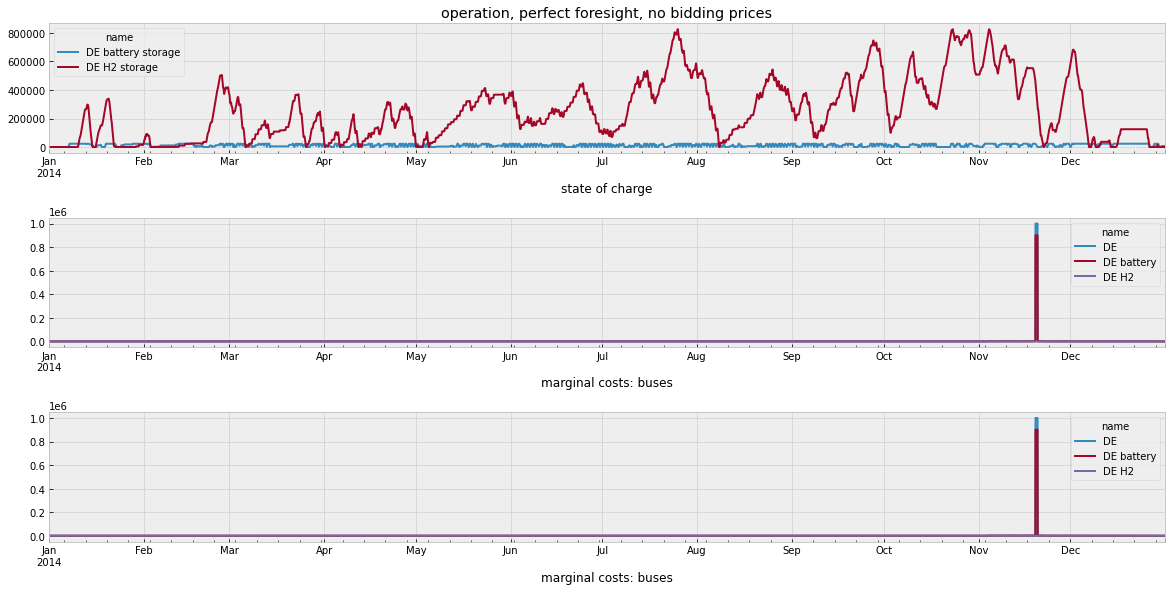

In [46]:
where='2014'

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,9))
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

n_operation.stores_t.e.loc[where].plot(ax=ax1)
ax1.set_title('operation, perfect foresight, no bidding prices')
ax1.set_xlabel('state of charge')

n_operation.buses_t.marginal_price.loc[where].plot(ax=ax2)
ax2.set_xlabel('marginal costs: buses')

n_de_rh_2w_h2.buses_t.marginal_price.loc[where].plot(ax=ax3)
ax3.set_xlabel('marginal costs: buses')

#fig.savefig(f'../plots/01-operation.jpeg')
plt.show()

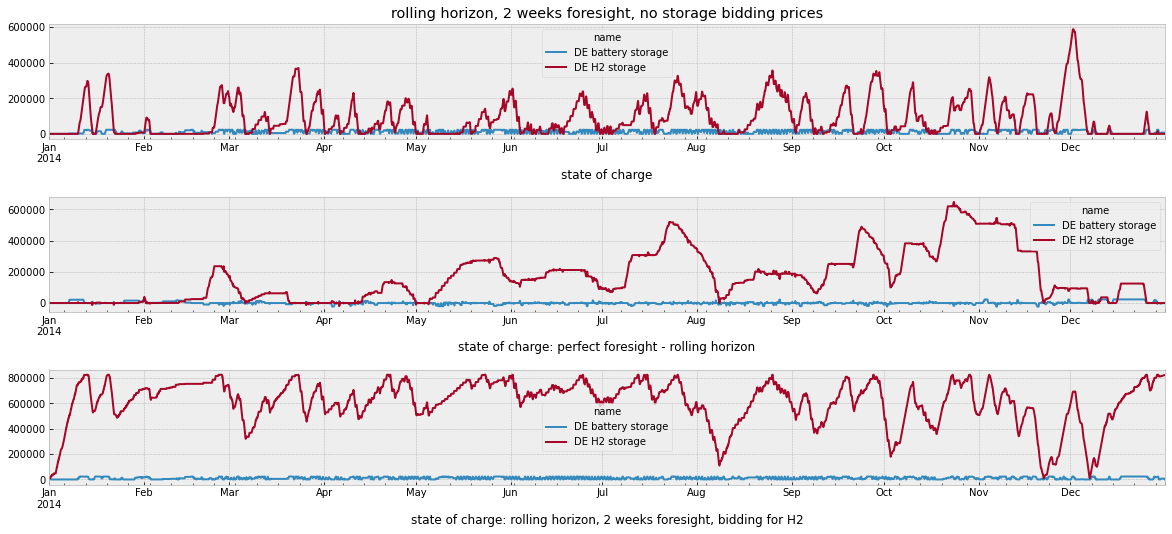

In [39]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

n_de_rh.stores_t.e.plot(ax=ax1)
ax1.set_title('rolling horizon, 2 weeks foresight, no storage bidding prices')
ax1.set_xlabel('state of charge')

(n_operation.stores_t.e-n_de_rh.stores_t.e).plot(ax=ax2)
ax2.set_xlabel('state of charge: perfect foresight - rolling horizon')

n_de_rh_2w_h2.stores_t.e.plot(ax=ax3)
ax3.set_xlabel('state of charge: rolling horizon, 2 weeks foresight, bidding for H2')

#fig.savefig(f'../plots/02-rh.jpeg')
plt.show()

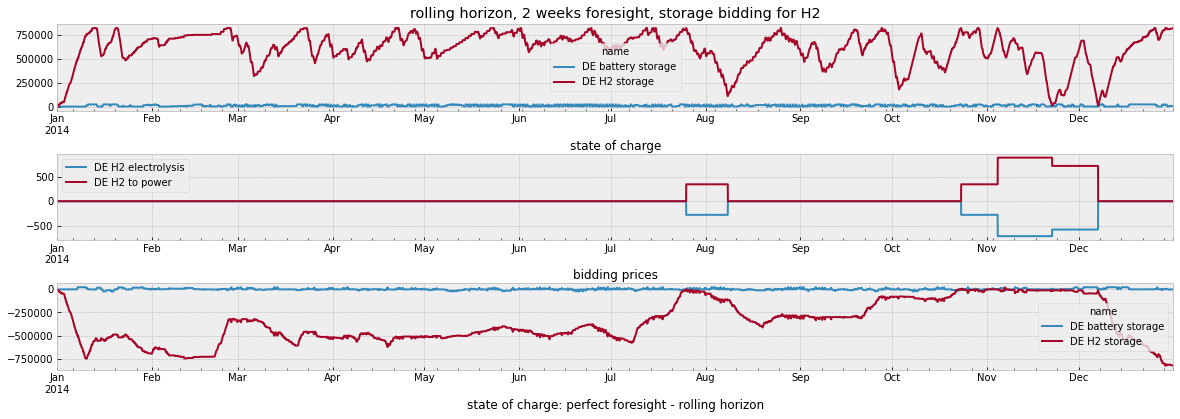

In [36]:
where='2014'

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,6))
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

n_de_rh_2w_h2.stores_t.e.loc[where].plot(ax=ax1)
ax1.set_title('rolling horizon, 2 weeks foresight, storage bidding for H2')
ax1.set_xlabel('state of charge')

n_de_rh_2w_h2.links_t.marginal_cost.loc[where].plot(ax=ax2)
ax2.set_xlabel('bidding prices')

(n_operation.stores_t.e-n_de_rh_2w_h2.stores_t.e).plot(ax=ax3)
ax3.set_xlabel('state of charge: perfect foresight - rolling horizon')

#fig.savefig(f'../plots/03-rh-h2.jpeg')
plt.show()

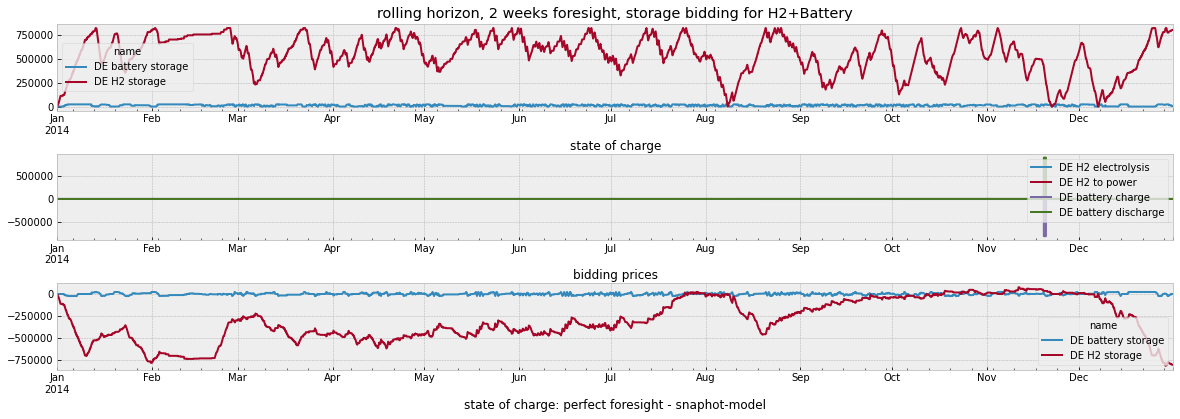

In [37]:
where='2014'

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,6))
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

n_de_rh_2w_all.stores_t.e.loc[where].plot(ax=ax1)
ax1.set_title('rolling horizon, 2 weeks foresight, storage bidding for H2+Battery')
ax1.set_xlabel('state of charge')

n_de_rh_2w_all.links_t.marginal_cost.loc[where].plot(ax=ax2)
ax2.set_xlabel('bidding prices')

(n_operation.stores_t.e-n_de_rh_2w_all.stores_t.e).plot(ax=ax3)
ax3.set_xlabel('state of charge: perfect foresight - snaphot-model')

#fig.savefig(f'../plots/{version}/04-rh-h2+b.jpeg')
plt.show()

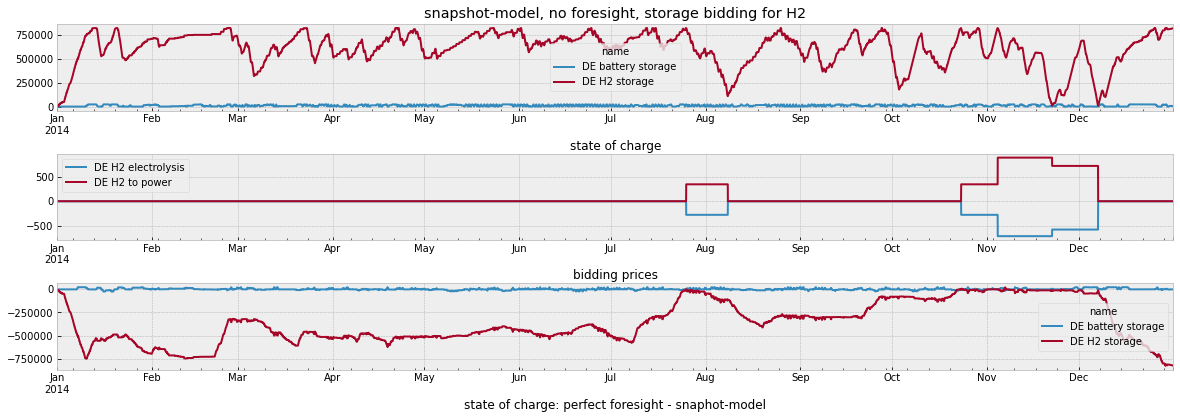

In [43]:
where='2014'

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,6))
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

n_de_rh_2w_h2.stores_t.e.loc[where].plot(ax=ax1)
ax1.set_title('snapshot-model, no foresight, storage bidding for H2')
ax1.set_xlabel('state of charge')

n_de_rh_2w_h2.links_t.marginal_cost.loc[where].plot(ax=ax2)
ax2.set_xlabel('bidding prices')

(n_operation.stores_t.e-n_de_rh_2w_h2.stores_t.e).plot(ax=ax3)
ax3.set_xlabel('state of charge: perfect foresight - snaphot-model')

#fig.savefig(f'../plots/05-snapshot-h2.jpeg')
plt.show()

NameError: name 'n_de_rh_sp_all' is not defined

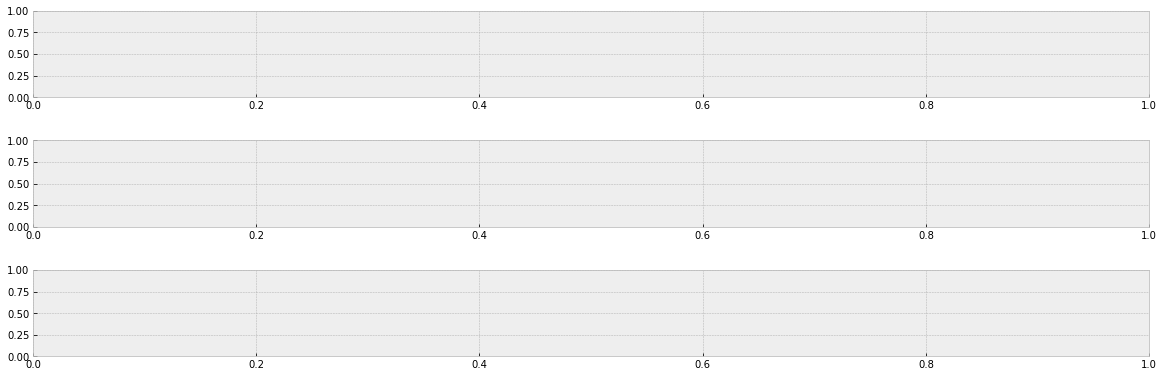

In [40]:
# where='2014'

# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,6))
# plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=.5, wspace=0)

# n_de_rh_sp_all.stores_t.e.loc[where].plot(ax=ax1)
# ax1.set_title('snapshot-model, no foresight, storage bidding for H2+Battery')
# ax1.set_xlabel('state of charge')

# n_de_rh_sp_all.links_t.marginal_cost.loc[where].plot(ax=ax2)
# ax2.set_xlabel('bidding prices')

# (n_operation.stores_t.e-n_de_rh_sp_all.stores_t.e).plot(ax=ax3)
# ax3.set_xlabel('state of charge: perfect foresight - snaphot-model')

# fig.savefig(f'../plots/06-snapshot-h2+b.jpeg')
# plt.show()